In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import xscale.signal.fitting as xsf
import matplotlib.dates as mdates
from datetime import *
now = datetime.now()
date_time = now.strftime("%d/%m/%Y")

def ano_norm_t(ds):
    
    '''Compute the anomalies by removing the monthly means. 
    The anomalies are normalized by their corresponding month.
    
    Parameters
    ----------
    
    ds : xarray_like
    Timeserie or 3d field.
    
    Returns
    -----------
    
    ano : xarray_like
    Returns the anomalies of var relative the climatology.
    
    ano_norm : xarray_like
    Returns the anomalies of var relative the climatology normalized by the standard deviation.
    
    '''    
    
    clim     = ds.groupby('time.month').mean('time')
    clim_std = ds.groupby('time.month').std('time')
    ano      = ds.groupby('time.month') - clim
    ano_norm = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                    ds.groupby('time.month'),
                                    clim, clim_std)
    
    return ano, ano_norm 


def read_data_compute_anomalies(path_data):
    
    ds = xr.open_dataset(path_data,engine='pydap')
    sst= ds.sst.sel(time=slice(datetime(1982, 1, 1), now))
    sst = xr.concat([sst[:, :, 180:], sst[:, :, :180]], dim='lon')
    sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180  
    
    ## Make sub areas ##
    sst_atl3 = sst.where((  sst.lon>=-20) & (sst.lon<=0) &
                           (sst.lat<=3) & (sst.lat>=-3),drop=True).mean(dim='lon').mean(dim='lat')
    sst_aba = sst.where((  sst.lon>=8) & (sst.lon<=16) &
                           (sst.lat<=-10) & (sst.lat>=-20),drop=True).mean(dim='lon').mean(dim='lat')
    
    
    ## Linearly detrend the data ## 
    
    
    sst_atl3 = sst_atl3.chunk(chunks=None)
    sst_atl3_dtd = xsf.detrend(sst_atl3,dim='time',type='linear')
    
    sst_aba = sst_aba.chunk(chunks=None)
    sst_aba_dtd = xsf.detrend(sst_aba,dim='time',type='linear')
    
    
    ## Compute the SST anomalies ## 

    
    ssta_atl3,ssta_atl3_norm = ano_norm_t(sst_atl3_dtd.load())
    ssta_aba,ssta_aba_norm = ano_norm_t(sst_aba_dtd.load())
    
    
    return ssta_atl3_norm,ssta_aba_norm


def plot_anomalies(ssta_atl3,ssta_aba):
    
    f,ax = plt.subplots(2,1,figsize=[15,10])
    color_lines='grey'
    ftz=15
    ax=ax.ravel()
    
    ### ATL3 ###
    ax[0].axhline(0,color=color_lines)
    ax[0].axhline(1,color=color_lines,linestyle='--')
    ax[0].axhline(-1,color=color_lines,linestyle='--')
    ax[0].plot(ssta_atl3.time.values,ssta_atl3,color='black')
    years = mdates.YearLocator(5)   # every year
    years_minor = mdates.YearLocator(1)  # every month
    ax[0].xaxis.set_major_locator(years)
    ax[0].xaxis.set_minor_locator(years_minor)
    ax[0].tick_params(labelsize=ftz)
    ax[0].fill_between(ssta_atl3.time.values,ssta_atl3,1,ssta_atl3>1,color='red')
    ax[0].fill_between(ssta_atl3.time.values,ssta_atl3,-1,ssta_atl3<-1,color='blue')
    ax[0].set_title('Normalized SST anomalies ATL3 [20W-0; 3S-3N]',fontsize=ftz,fontweight='bold')
    ### ABA ###
    ax[1].set_title('Normalized SST anomalies ABA [8E-16E; 20S-10S]',fontsize=ftz,fontweight='bold')
    ax[1].plot(ssta_aba.time,ssta_aba,color='black')
    ax[1].axhline(0,color=color_lines)
    ax[1].axhline(1,color=color_lines,linestyle='--')
    ax[1].axhline(-1,color=color_lines,linestyle='--')
    
    years = mdates.YearLocator(5)   # every 5 years
    years_minor = mdates.YearLocator(1)  # every year
    ax[1].xaxis.set_major_locator(years)
    ax[1].xaxis.set_minor_locator(years_minor)
    ax[1].tick_params(labelsize=ftz)
    ax[1].fill_between(ssta_aba.time.values,ssta_aba,1,ssta_aba>1,color='red')
    ax[1].fill_between(ssta_aba.time.values,ssta_aba,-1,ssta_aba<-1,color='blue')

# COBE SST 

In [39]:
path_data = 'https://psl.noaa.gov/thredds/dodsC/Datasets/COBE/sst.mon.mean.nc'

In [40]:
ssta_atl3_norm,ssta_aba_norm = read_data_compute_anomalies(path_data)

/anaconda3/lib/python3.7/site-packages/dask/array/linalg.py:1076: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.array([0, 1], dtype=b.dtype))


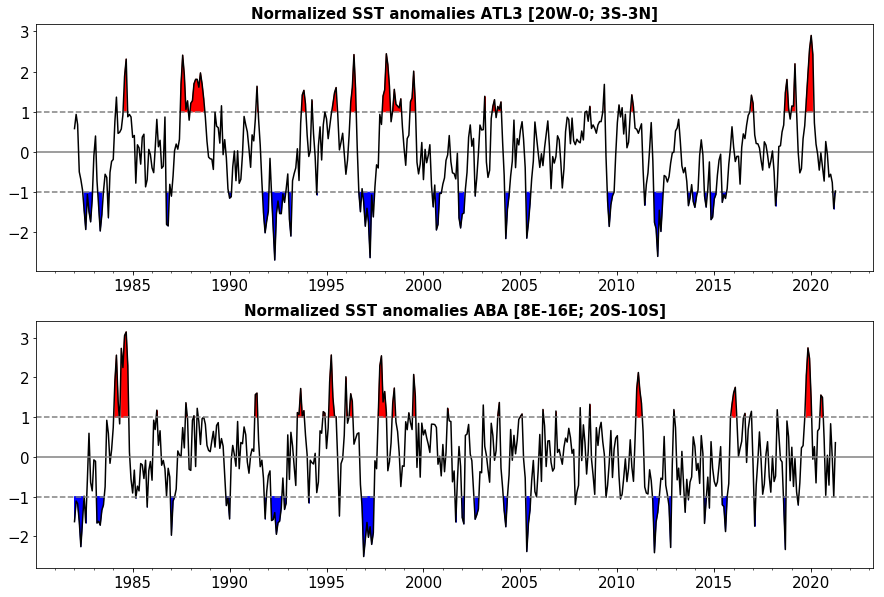

In [43]:
plot_anomalies(ssta_atl3_norm,ssta_aba_norm)